In [1]:
from sentence_transformers import SentenceTransformer, models, util
import csv 
import json
import numpy as np
from torch import nn
from blingfire import text_to_sentences
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

/home/yunyi/.conda/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## prepare the sentence embedding and sentences

sentence embedding

In [2]:
word_embedding_model = models.Transformer('../../ZhiGuoLiZheng/pretrained/ZhiGuoLiZheng-BERT', # "yshen99/ZhiGuoLiZheng-BERT", # in case remote
                                        max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension()) # default: mean pooling, may try other methods
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), 
                            out_features=256, activation_function=nn.Tanh())

model = SentenceTransformer(modules=[word_embedding_model, 
                                    pooling_model, 
                                    dense_model])

Some weights of the model checkpoint at ../../ZhiGuoLiZheng/pretrained/ZhiGuoLiZheng-BERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../../ZhiGuoLiZheng/pretrained/ZhiGuoLiZheng-BERT and are newly initialized

prepare all sentences

In [3]:
#reports = [] # the full reports
sentences = [] # sentences
num_sentences = [] # number of sentences in each report

with open("../data/congress_report/congress_report_full_len.txt") as reader:
	lines = reader.readlines()
	for line in lines:
		#reports.append(line)
		tmp = text_to_sentences(line).splitlines()
		num_sentences.append(len(tmp))
		sentences.extend(tmp)

## embedding and clustering

embed the sentence into a 256 dimension space

In [4]:
sen_ecd = model.encode(sentences)

cluster with k-means

In [44]:
n_clusters = 15
kmeans = KMeans(n_clusters, random_state=0, n_init="auto").fit(sen_ecd)

visualize it a bit

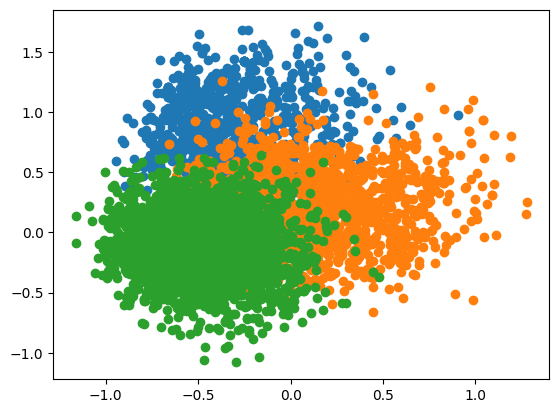

In [51]:
pca = PCA(2)
#Transform the data
ecd_2d = pca.fit_transform(sen_ecd)
first_5_clusters = [ecd_2d[kmeans.labels_==i] for i in range(5)]
for i in range(3):
    plt.scatter(first_5_clusters[i][:,0], first_5_clusters[i][:,1])


do some check 

In [46]:
for i in range(3):
    print(np.array(sentences)[kmeans.labels_==i][range(5)])

['各位代表：[SEP]\u3000\u3000现在，我代表国务院，向大会报告政府工作，请各位代表审议，并请全国政协委员提出意见[SEP]一、2011年工作回顾.[SEP]\u3000\u3000过去的一年，面对复杂多变的国际政治经济环境和艰巨繁重的国内改革发展任务，全国各族人民在中国共产党领导下，同心同德，团结奋进，改革开放和社会主义现代化建设取得新的重大成就。'
 '这是以胡锦涛同志为总书记的党中央科学决策、正确领导的结果，是全党全军全国各族人民齐心协力、顽强拼搏的结果。'
 '[SEP]\u3000\u3000我代表国务院，向全国各族人民，向各民主党派、各人民团体和各界人士，表示诚挚的感谢！'
 '向香港特别行政区同胞、澳门特别行政区同胞、台湾同胞和海外侨胞，表示诚挚的感谢！'
 '向关心和支持中国现代化建设的各国政府、国际组织和各国朋友，表示诚挚的感谢！']
['我们巩固和扩大了应对国际金融危机冲击成果，实现了“十二五”时期良好开局。'
 '[SEP]\u3000\u3000一年来，我们主要做了以下工作：[SEP]（一）加强和改善宏观调控，遏制物价过快上涨，实现经济平稳较快发展。'
 '.[SEP]\u3000\u3000我们实施积极的财政政策和稳健的货币政策，坚持正确处理保持经济平稳较快发展、调整经济结构和管理通胀预期的关系，更加注重把握好政策实施的重点、力度和节奏，努力做到调控审慎灵活、适时适度，不断提高政策的针对性、灵活性和前瞻性。'
 '[SEP]\u3000\u3000在全球通胀预期不断增强，国际市场大宗商品价格高位波动，国内要素成本明显上升，部分农产品供给偏紧的严峻形势下，我们把稳定物价总水平作为宏观调控的首要任务，坚持综合施策，合理运用货币政策工具，调节货币信贷增速，大力发展生产，保障供给，搞活流通，加强监管，居民消费价格指数、工业生产者出厂价格指数涨幅从8月份起逐月回落，扭转了一度过快上涨势头。'
 '[SEP]\u3000\u3000下半年，世界经济不稳定性不确定性上升，国内经济运行出现一些新情况新问题，我们一方面坚持宏观调控的基本取向不变，保持宏观经济政策基本稳定，继续控制通货膨胀；一方面适时适度预调微调，加强信贷政策与产业政策的协调配合，加大结构性减税力度，重点支持实体经济特别是小型微型企业，重点支持民生工程特别是保障性安居工程，重点保

take a look at several years

In [47]:
decades = np.array([37, 45, 2, 26, 25]) # 1980, 90, 2000, 2010, 2020
start_sentence = np.cumsum(num_sentences)

In [48]:
start_sentence = np.insert(start_sentence, 0, 0)
clusters_decades = [kmeans.labels_[start_sentence[i]:start_sentence[i+1]] for i in decades]

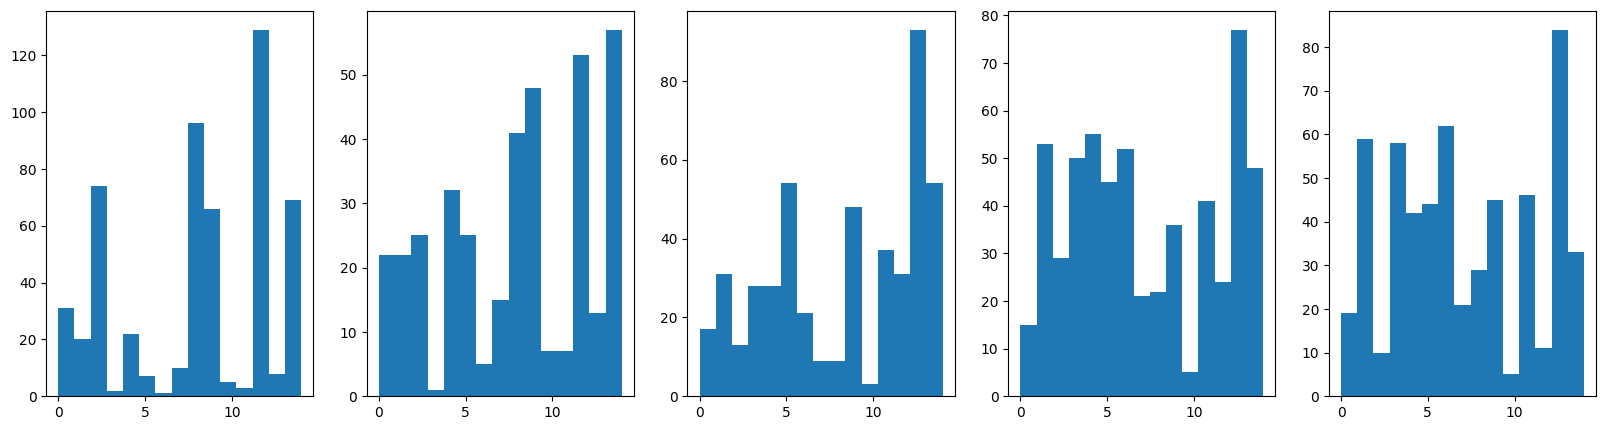

In [49]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    # plt.hist(clusters_decades[i], bins=20)
    axes[i].hist(clusters_decades[i], bins=n_clusters)

plt.show()

In [52]:
print(np.array(sentences)[kmeans.labels_==6][range(15)])
print(np.array(sentences)[kmeans.labels_==14][range(15)])

['继续推进农村危房改造，解决了6398万农村人口的饮水困难和60万无电地区人口的用电问题，农村生产生活条件进一步改善。'
 '制定实施新10年农村扶贫开发纲要和兴边富民行动规划。'
 '免除3000多万名农村寄宿制学生住宿费，其中1228万名中西部家庭经济困难学生享受生活补助。' '建立起完整的家庭经济困难学生资助体系。'
 '初步解决农民工随迁子女在城市接受义务教育的问题。' '[SEP]\u3000\u3000推动实施“学前教育三年行动计划”，提高幼儿入园率。'
 '加强中小学教师培训工作，扩大中小学教师职称制度改革试点，提高中小学教师队伍整体素质。' '首届免费师范生全部到中小学任教，90％以上在中西部。'
 '基本医疗保险覆盖范围继续扩大，13亿城乡居民参保，全民医保体系初步形成。'
 '政策范围内住院费用报销比例提高，重大疾病医疗保障病种范围进一步扩大。'
 '各级财政对城镇居民医保和新农合的补助标准由每人每年120元提高到200元。'
 '国家基本药物制度在政府办基层医疗卫生机构实现全覆盖，基本药物安全性提高、价格下降。'
 '加大财政、税收、金融等方面支持力度，着力促进高校毕业生、农民工等重点人群就业。' '高校毕业生初次就业率77.8％，同比提高1.2个百分点。'
 '着力提高低收入群众收入。']
['交通运输产业快速发展，经济社会发展的基础进一步夯实。'
 '[SEP]\u3000\u3000城镇化率超过50％，这是中国社会结构的一个历史性变化。'
 '社会保障体系不断健全，向制度全覆盖迈出重大步伐，这是推进基本公共服务均等化取得的重要成就。'
 '[SEP]\u3000\u3000我们在民主法制建设、国防和军队建设、港澳台工作和外交工作等方面，都取得了卓有成效的进展。'
 '[SEP]\u3000\u3000过去一年的成绩来之不易，显示了中国特色社会主义的优越性和生命力，增强了中华民族的自豪感和凝聚力。'
 '[SEP]\u3000\u3000我们要高举中国特色社会主义伟大旗帜，以邓小平理论和“三个代表”重要思想为指导，深入贯彻落实科学发展观，坚持稳中求进，加强和改善宏观调控，继续处理好保持经济平稳较快发展、调整经济结构和管理通胀预期的关系，加快推进经济发展方式转变和经济结构调整，着力扩大国内需求特别是消费需求，着力加强自主创新和节能减排，着力